# Time Series Forecasting with XGBoost & Cross-Validation 

In [176]:
import pandas as pd
import numpy as np 
import seaborn as sns
color_pal = sns.color_palette()
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import xgboost as xgb
from sklearn.metrics import mean_squared_error

#cross validation imports
from sklearn.model_selection import TimeSeriesSplit

In [177]:
df = pd.read_csv('PJME_hourly.csv')

### Set Index as Datetime
df = df.set_index('Datetime')

#Change Datetime Datatype to Datetime
df.index = pd.to_datetime(df.index)

## Data Exploration & Cleaning

In [178]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [179]:
df.shape

(145366, 1)

In [180]:
df.dtypes

PJME_MW    float64
dtype: object

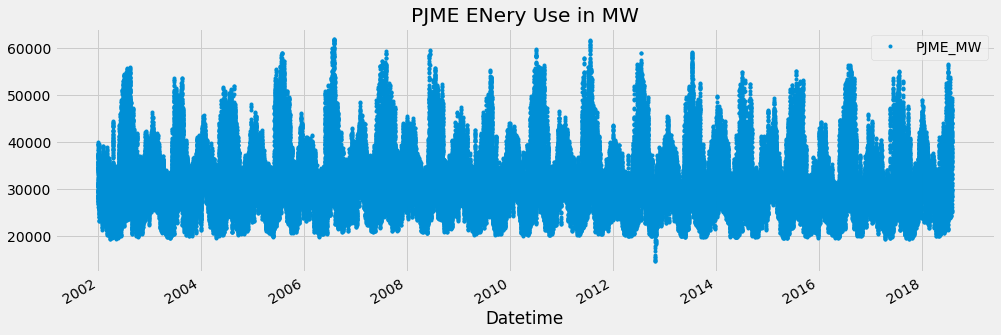

In [181]:
df.plot(style = '.', 
        figsize = (15, 5), 
        color = color_pal[0], 
        title = 'PJME ENery Use in MW');

We can notice some outliers in between 2012-2014, where there are values under 20,000MW. It is better to remove these outliners in order for the model to predict more accurately.  

### Outlier Analysis and Removal

In [182]:
mean_MW = df['PJME_MW'].mean()
mean_MW

32080.222830648156

### Histogram

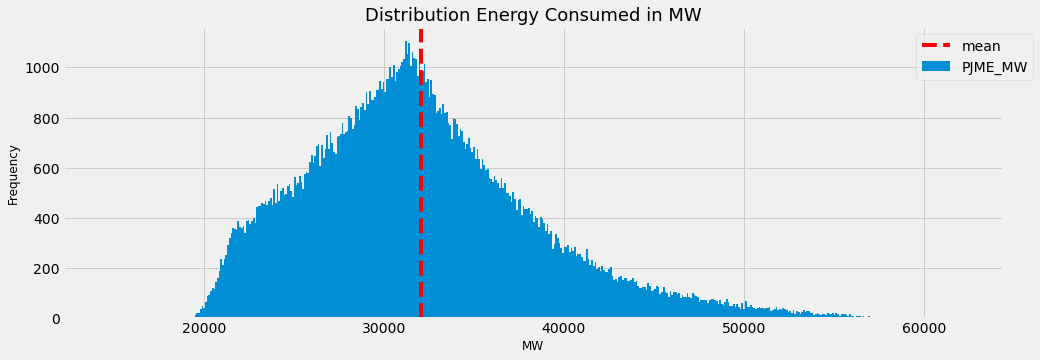

In [183]:
df['PJME_MW'].plot(figsize = (15,5), kind = 'hist', bins = 500)

plt.title('Distribution Energy Consumed in MW', fontsize=18)

plt.xlabel('MW', fontsize=12)

plt.ylabel('Frequency', fontsize=12)

plt.axvline(x=mean_MW, color='r', linestyle = '--', label = 'mean')

plt.legend(bbox_to_anchor=(1.04,1));

### Locate when the values are less than 20,000 MW

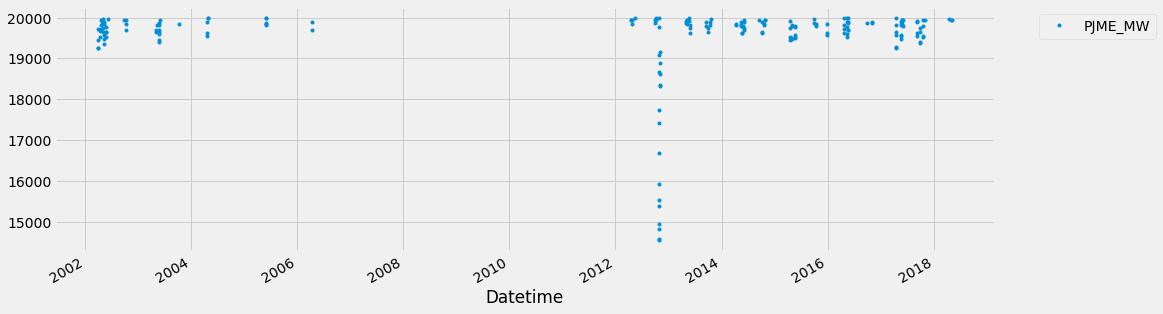

In [184]:
df.query('PJME_MW < 20000').plot(figsize = (15,5), style = '.')
plt.legend(bbox_to_anchor=(1.04,1));

Looks like the values tend to drop below 20,000 MW, however, there are only one specific section, when the values drop below 19,000.

### Locate when the values are less than 19,000 MW

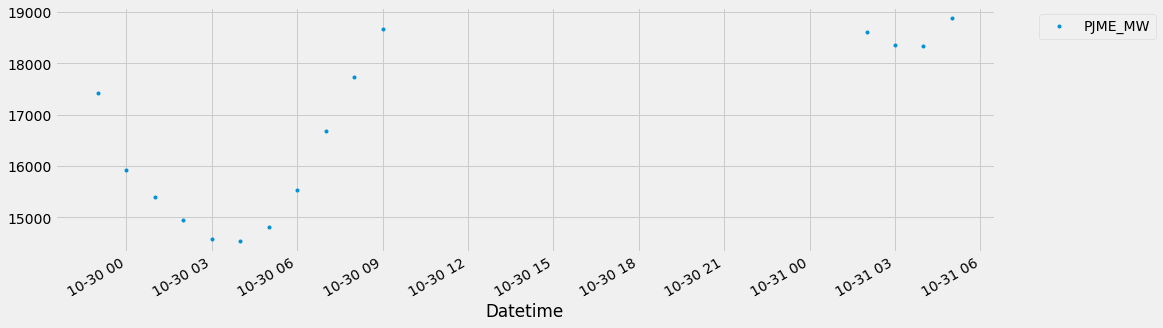

In [185]:
df.query('PJME_MW < 19000').plot(figsize = (15,5), style = '.')
plt.legend(bbox_to_anchor=(1.04,1));

### Make a Copy of All The Data That Is Over 19,000 MW and Assign it to a New DataFrame

In [186]:
df = df[df['PJME_MW'] > 19000].copy()



## Time Series Cross Validation

In [187]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)
df = df.sort_index()

In [188]:
for train_index, val_index in tss.split(df):
    break

#### Training Set Indices

In [189]:
train_index

array([     0,      1,      2, ..., 101524, 101525, 101526])

#### Validation indices

In [190]:
val_index

array([101551, 101552, 101553, ..., 110308, 110309, 110310])

### Plot Cross Validation Sets

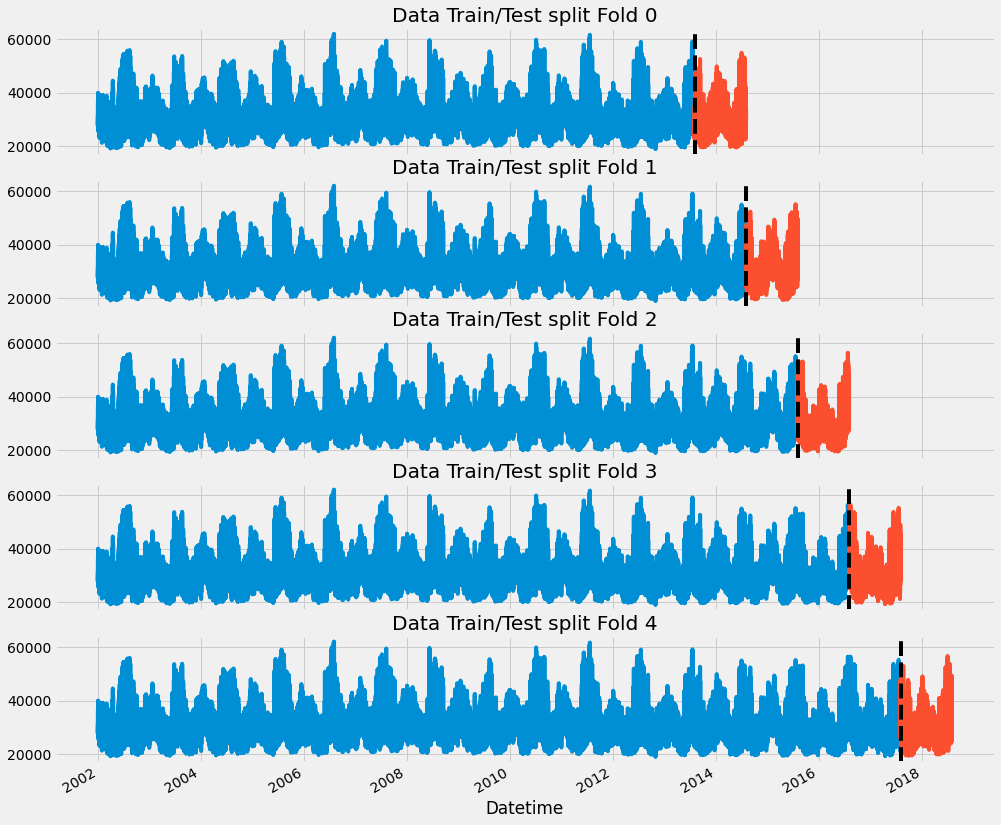

In [191]:
fig, axs = plt.subplots(5, 1,figsize = (15,15), sharex=True)

fold = 0
for train_index, val_index in tss.split(df):
    train =df.iloc[train_index]
    test = df.iloc[val_index]
    train['PJME_MW'].plot(ax = axs[fold],
                         label = 'Training Set',
                         title = f'Data Train/Test split Fold {fold}')
    test['PJME_MW'].plot(ax = axs[fold], label = 'Test Set')
    
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold += 1

According to the visualization above, we are testing each of the past 5 years of our data independently to each other.

## Forecasting Horizon Explained

The length of time into future for which forecasts are to be prepared.

### Time Series Features

In [192]:
def create_features(df):
    """
    Create time series features based on time series index. 
    """
    df.copy()
    df['Hour'] = df.index.hour
    df['Day_of_Week'] = df.index.dayofweek
    df['Quarter'] = df.index.quarter
    df['Month'] =  df.index.month
    df['Year'] = df.index.year
    df['Day_of_Year'] = df.index.dayofyear
    df['Day_of_Month'] = df.index.day
    df['Week_of_Year'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Lag Features

States for the model to look back in to past data (as many years/months/days as required) and use the target value for that many days in the past as a new feature to insert into the model.

### Create A Dictinary In Order to Map The Lag Features On To The DataFrame

In [193]:
target_map = df['PJME_MW'].to_dict()

In [194]:
def add_lags(df): 
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [195]:
df = add_lags(df)

In [196]:
df

,PJME_MW,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year,Day_of_Month,Week_of_Year,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0


## Train Using Cross Validation

In [197]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_index, val_index in tss.split(df):
    train =df.iloc[train_index]
    test = df.iloc[val_index]

    ###run the train and test sets through create fetures function 5 different times
    train = create_features(train)
    test = create_features(test)

    ### Define the features including the lags
    FEATURES = ['Hour', 'Day_of_Week', 'Quarter', 'Month', 'Year','Day_of_Year','lag1','lag2','lag3']
    TARGET = 'PJME_MW'
    
    
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                           n_estimators = 1000, 
                           early_Stopping_rounds=50,
                           objective = 'reg:linear',
                           max_depth = 3,
                           learning_rate = 0.01)

    reg.fit(X_train, y_train,
           eval_set = [(X_train, y_train), (X_test, y_test)],
           verbose = 100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    # give score to the model
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    #save the scores into list
    scores.append(score)

[14:38:19] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:38:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_Stopping_rounds" } are not used.

[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494


<ipython-input-192-43087d14da1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df.index.hour
<ipython-input-192-43087d14da1f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Week'] = df.index.dayofweek
<ipython-input-192-43087d14da1f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[500]	validation_0-rmse:3313.95004	validation_1-rmse:3770.74455
[600]	validation_0-rmse:3257.51011	validation_1-rmse:3785.44964
[700]	validation_0-rmse:3217.49502	validation_1-rmse:3793.83839
[800]	validation_0-rmse:3183.53053	validation_1-rmse:3801.68437
[900]	validation_0-rmse:3155.13209	validation_1-rmse:3788.88823
[999]	validation_0-rmse:3122.54432	validation_1-rmse:3780.82874
[14:38:39] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:38:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_Stopping_rounds" } are not used.

[0]	validation_0-rmse:32672.

<ipython-input-192-43087d14da1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df.index.hour
<ipython-input-192-43087d14da1f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Week'] = df.index.dayofweek
<ipython-input-192-43087d14da1f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.97626
[200]	validation_0-rmse:5755.14393	validation_1-rmse:5649.54800
[300]	validation_0-rmse:3909.18294	validation_1-rmse:3930.98277
[400]	validation_0-rmse:3477.91771	validation_1-rmse:3603.77859
[500]	validation_0-rmse:3356.63775	validation_1-rmse:3534.18452
[600]	validation_0-rmse:3299.24378	validation_1-rmse:3495.69013
[700]	validation_0-rmse:3258.86466	validation_1-rmse:3470.24780
[800]	validation_0-rmse:3222.68998	validation_1-rmse:3446.36557
[900]	validation_0-rmse:3195.04645	validation_1-rmse:3438.00845
[999]	validation_0-rmse:3169.68251	validation_1-rmse:3434.35289


<ipython-input-192-43087d14da1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df.index.hour
<ipython-input-192-43087d14da1f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Week'] = df.index.dayofweek
<ipython-input-192-43087d14da1f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

[14:39:00] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:39:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_Stopping_rounds" } are not used.

[0]	validation_0-rmse:32631.19070	validation_1-rmse:31073.24659
[100]	validation_0-rmse:12498.56469	validation_1-rmse:11133.47932
[200]	validation_0-rmse:5749.48268	validation_1-rmse:4812.56835
[300]	validation_0-rmse:3915.69493	validation_1-rmse:3552.97165
[400]	validation_0-rmse:3493.17887	validation_1-rmse:3492.55244
[500]	validation_0-rmse:3378.10109	validation_1-rmse:3549.00712
[600]	validation_0-rmse:3320.73719	validation_1-rmse:3606.53285
[700]	validation_0-rmse:3279.23270	validation_1-rmse:3632.27052
[800]	validation_0-rmse:3248.24624	validation_1-rmse:3654.66654
[900]	validation_0-rmse:3222.81600	validation_1-rmse:3692.31165
[999]	validation_0-rmse:3192

<ipython-input-192-43087d14da1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df.index.hour
<ipython-input-192-43087d14da1f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Week'] = df.index.dayofweek
<ipython-input-192-43087d14da1f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

[14:39:22] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:39:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_Stopping_rounds" } are not used.

[0]	validation_0-rmse:32528.44140	validation_1-rmse:31475.37803
[100]	validation_0-rmse:12461.95683	validation_1-rmse:12016.24890
[200]	validation_0-rmse:5736.08201	validation_1-rmse:5800.02075
[300]	validation_0-rmse:3913.36576	validation_1-rmse:4388.02984
[400]	validation_0-rmse:3495.35688	validation_1-rmse:4177.05330
[500]	validation_0-rmse:3380.70922	validation_1-rmse:4123.58982
[600]	validation_0-rmse:3321.42955	validation_1-rmse:4111.15127
[700]	validation_0-rmse:3280.93068	validation_1-rmse:4096.76974
[800]	validation_0-rmse:3249.14336	validation_1-rmse:4095.68028
[900]	validation_0-rmse:3221.35968	validation_1-rmse:4089.42412
[999]	validation_0-rmse:3197

<ipython-input-192-43087d14da1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df.index.hour
<ipython-input-192-43087d14da1f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Week'] = df.index.dayofweek
<ipython-input-192-43087d14da1f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

[14:39:45] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:39:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_Stopping_rounds" } are not used.

[0]	validation_0-rmse:32462.05402	validation_1-rmse:31463.86930
[100]	validation_0-rmse:12445.22753	validation_1-rmse:11954.79556
[200]	validation_0-rmse:5750.85887	validation_1-rmse:5616.16472
[300]	validation_0-rmse:3949.92308	validation_1-rmse:4154.55799
[400]	validation_0-rmse:3538.33857	validation_1-rmse:3996.70155
[500]	validation_0-rmse:3427.81596	validation_1-rmse:4021.19840
[600]	validation_0-rmse:3370.35619	validation_1-rmse:4048.17054
[700]	validation_0-rmse:3332.28808	validation_1-rmse:4050.40977
[800]	validation_0-rmse:3302.10808	validation_1-rmse:4041.31458
[900]	validation_0-rmse:3276.56569	validation_1-rmse:4034.47952
[999]	validation_0-rmse:3252

### Illustrate the Scores

In [198]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3806.4519
Fold scores:[3780.828736907443, 3434.3528874818867, 3721.2959107610163, 4071.6241163521104, 4024.157699780812]


## Predicting the Future

In [199]:
## Retian on all data
df = create_features(df)

### Define the features including the lags
FEATURES = ['Hour', 'Day_of_Week', 'Quarter', 'Month', 'Year','Day_of_Year',
                'Day_of_Month','lag1','lag2','lag3']
TARGET = 'PJME_MW'
    
X_all = df[FEATURES]
y_all = df[TARGET]
    
reg = xgb.XGBRegressor(base_score = 0.5, 
                       booster = 'gbtree',
                       n_estimators = 1000, 
                       objective = 'reg:linear',
                       max_depth = 3,
                       learning_rate = 0.01)

reg.fit(X_all, y_all, 
        eval_set = [(X_all, y_all)],
        verbose = 100)

[14:40:10] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.44700
[200]	validation_0-rmse:5752.69704
[300]	validation_0-rmse:3970.08787
[400]	validation_0-rmse:3569.37848
[500]	validation_0-rmse:3453.91141
[600]	validation_0-rmse:3401.16957
[700]	validation_0-rmse:3364.78655
[800]	validation_0-rmse:3335.73507
[900]	validation_0-rmse:3309.71886
[999]	validation_0-rmse:3285.50830


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## Create future DataFrame

In [200]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [201]:
future = pd.date_range('2018-08-03','2019-08-01', freq = '1h')
future_df = pd.DataFrame(index = future)

future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])

# add the features
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)


In [202]:
df_and_future

,PJME_MW,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year,Day_of_Month,Week_of_Year,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [203]:
future_with_features = df_and_future.query('isFuture').copy()

In [204]:
future_with_features

,PJME_MW,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year,Day_of_Month,Week_of_Year,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


## Predict the Future

In [205]:
future_with_features['pred'] = reg.predict(future_with_features[FEATURES])

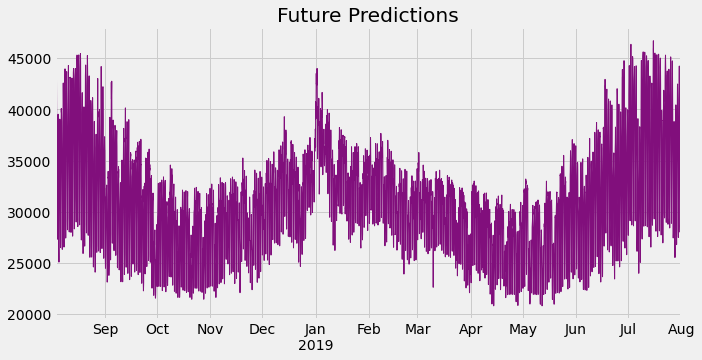

In [207]:
future_with_features['pred'].plot(figsize = (10,5),
                                 color = color_pal[5],
                                 ms=1,
                                 lw=1,
                                 title='Future Predictions');

XGBoost is a powerful and popular machine learning algorithm, especially for regression and classification tasks. However, like any other algorithm, it has its limitations and considerations when it comes to time series forecasting. Here are some of the limitations of using XGBoost for time series forecasting:

1. Lack of Temporal Understanding:
   - XGBoost is a tree-based model that does not inherently capture the sequential nature of time series data. It treats each data point as independent, which may not be suitable for tasks where the order and time dependencies of data are essential.

2. Stationarity Assumption:
   - XGBoost assumes that the statistical properties of the data do not change over time, which might not hold for many time series data. Time series data often exhibit trends, seasonality, and other temporal patterns that XGBoost may not handle well without proper preprocessing.

3. Seasonality Handling:
   - Dealing with seasonality (e.g., daily, weekly, or yearly patterns) in time series data can be challenging for XGBoost. While some preprocessing techniques can be applied, incorporating seasonality effectively may require domain-specific knowledge.

4. Handling Time Lags:
   - XGBoost doesn't inherently account for time lags, which are often crucial in time series forecasting. Lagged variables or other time-related features must be manually engineered and included in the model.

5. Hyperparameter Tuning:
   - XGBoost requires careful hyperparameter tuning, which can be time-consuming. In time series forecasting, it's essential to find the right balance between model complexity, regularization, and other hyperparameters.

6. Handling Missing Values:
   - Time series data often have missing values due to gaps or irregularities in data collection. Handling missing values appropriately can be challenging, and it requires additional preprocessing steps.

7. Forecast Horizon:
   - XGBoost's forecasting capabilities may be limited when predicting over long time horizons. Forecasts become less accurate as the time horizon increases, and short-term predictions are generally more reliable.

8. Large Datasets:
   - For very large time series datasets, training an XGBoost model can be computationally expensive and may require significant computational resources.

9. Model Interpretability:
   - While XGBoost is a powerful model, its black-box nature may make it challenging to interpret and explain forecasts, which can be important in some applications.

To address these limitations, practitioners often combine XGBoost with other time series forecasting techniques, such as autoregressive models (ARIMA), exponential smoothing (ETS), or Long Short-Term Memory (LSTM) networks, which are better suited for capturing temporal dependencies and handling seasonality. Additionally, preprocessing, feature engineering, and careful consideration of the problem domain play a crucial role in successful time series forecasting using XGBoost.